<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


C:\Users\rafae\AppData\Local\Temp\ipykernel_9208\1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


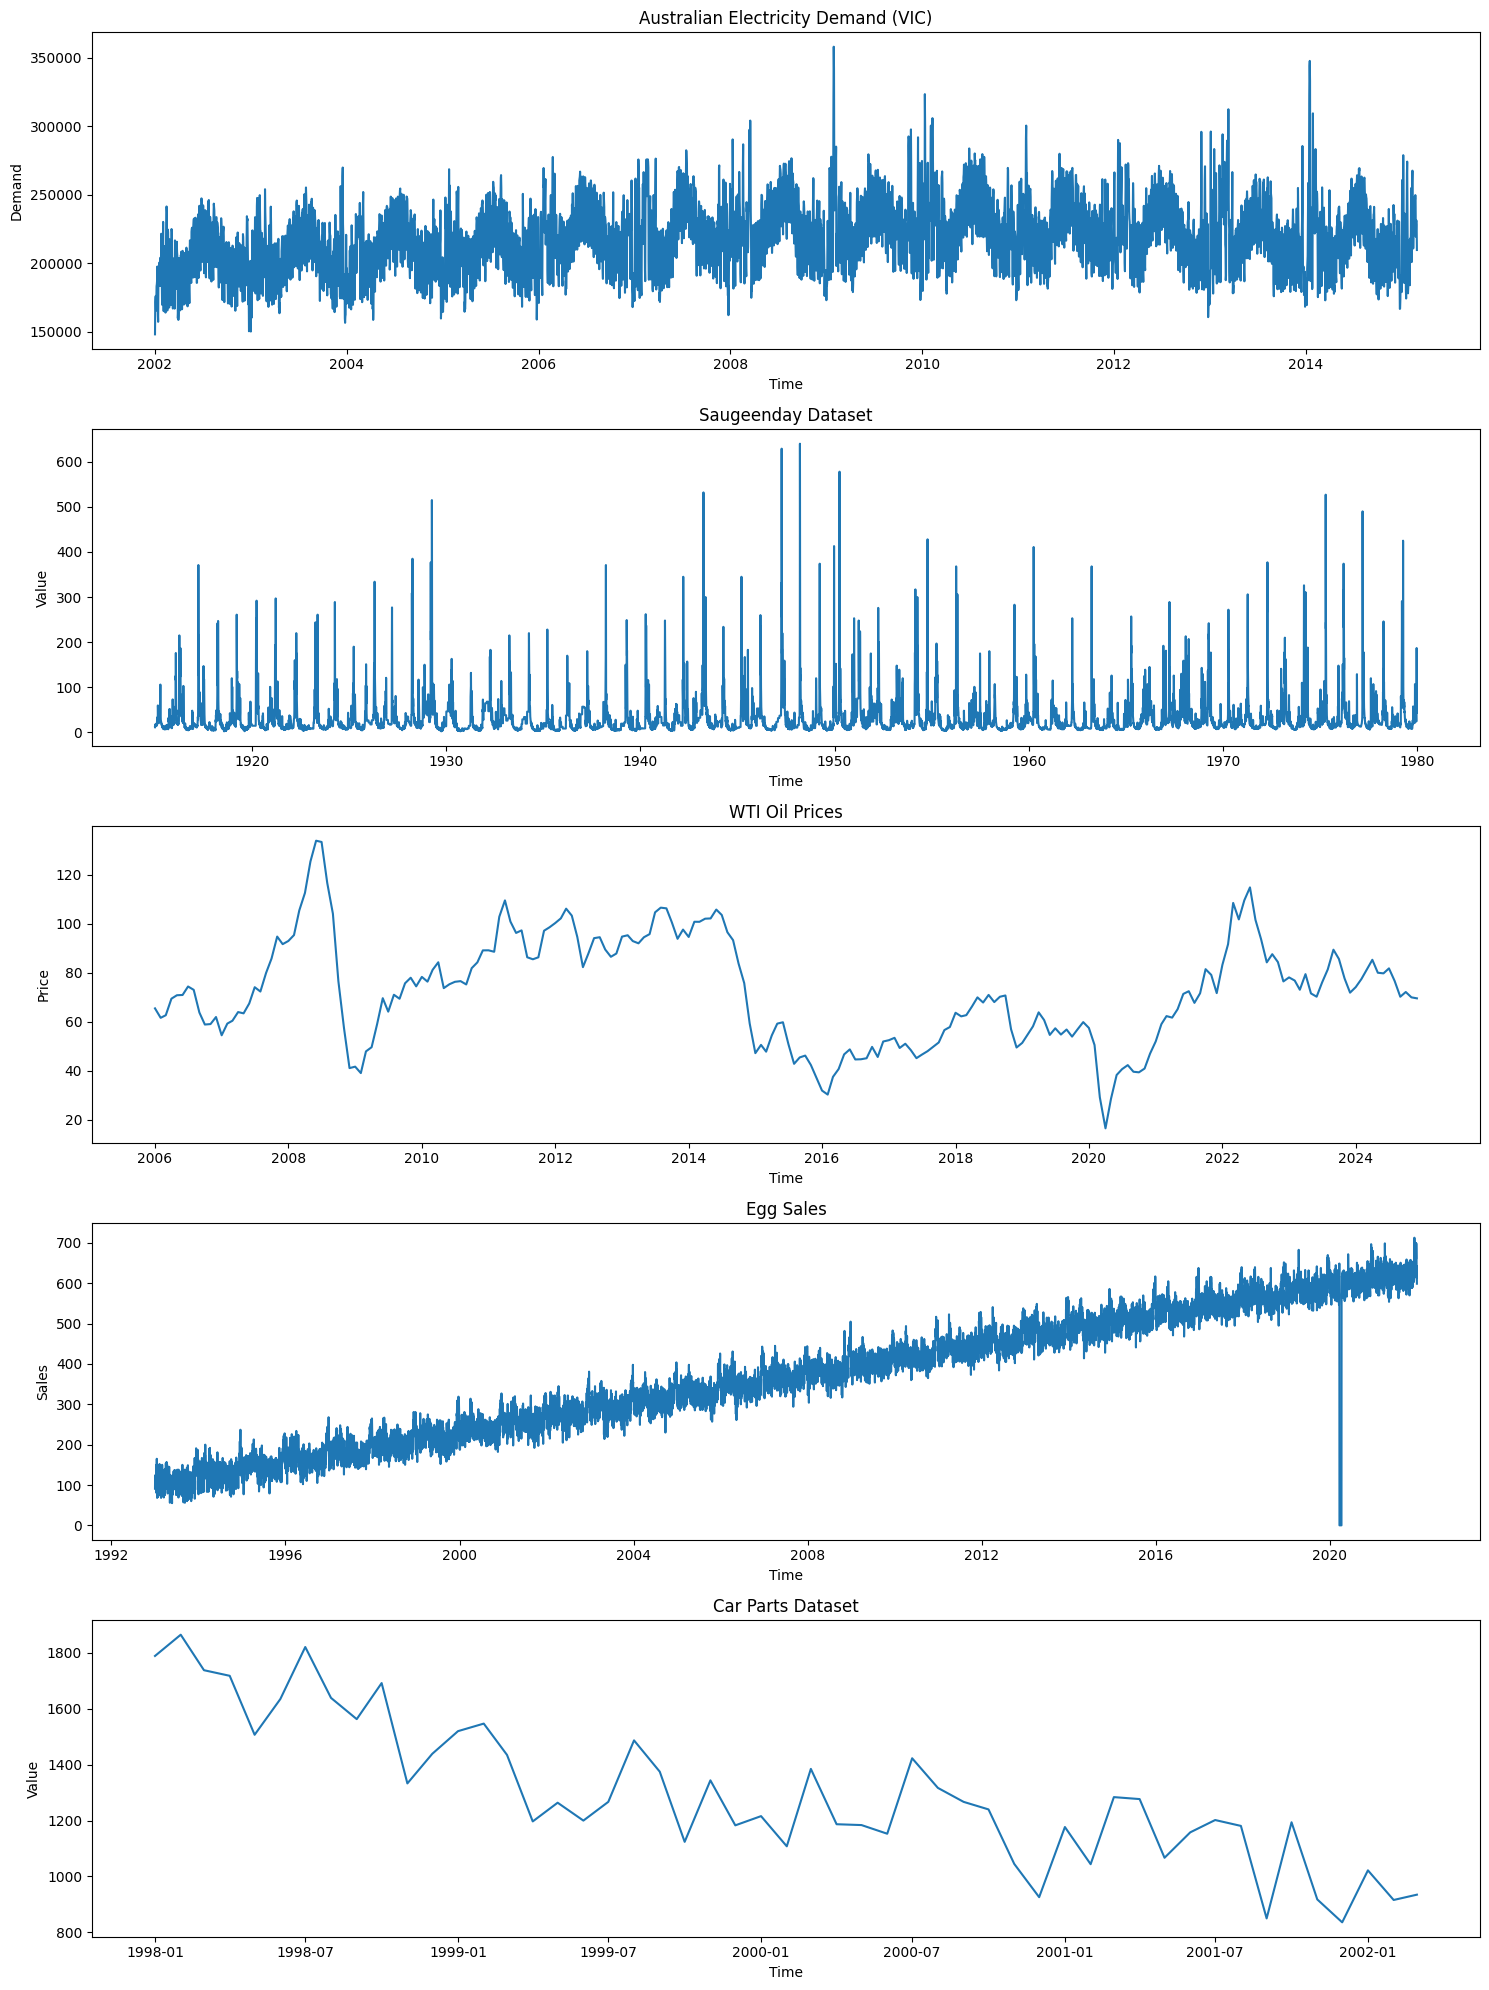

In [1]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

def prophet_forecast(
    train_df,         # train data
    test_df,          # test data
    alpha=0.05,         # alpha is the confidence interval
    show_plots=False,    # show plots
    figsize=(14, 6)    # figure size
):
    """
    Prophet forecast function.
    Returns only the predictions (np.ndarray) for the test set.
    """
    m = Prophet(interval_width=1-alpha)  # create a Prophet model
    m.fit(train_df)  # fit the model to the train data
    future = pd.concat([train_df[['ds']], test_df[['ds']]], ignore_index=True)  # concatenate the train and test data
    forecast = m.predict(future)  # predict the future

    # Only forecast for the test period
    forecast_test = forecast[forecast['ds'].isin(test_df['ds'])].copy()  # copy the forecast for the test data  
    forecast_test = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # select the columns we want
    test_df_sorted = test_df.sort_values('ds').reset_index(drop=True)  # sort the test data
    forecast_test_sorted = forecast_test.sort_values('ds').reset_index(drop=True)  # sort the forecast data

    # Plot if show_plots is True
    if show_plots:
        plt.figure(figsize=figsize)  # create a figure with the given size
        plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')  # plot the training data
        plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')  # plot the test data
        plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', color='darkorange')  # plot the prophet forecast
        plt.fill_between(forecast_test['ds'],  # fill the area between the lower and upper confidence intervals
                         forecast_test['yhat_lower'],  # lower confidence interval
                         forecast_test['yhat_upper'],  # upper confidence interval
                         color='orange', alpha=0.2, label=f'{int((1-alpha)*100)}% CI')  # fill the area with the given color and alpha
        split_date = test_df['ds'].iloc[0]  # get the split date
        plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')  # plot the split date
        plt.title('Prophet Forecast')  # title of the plot
        plt.xlabel('Date')  # x-axis label
        plt.ylabel('Value')  # y-axis label
        plt.legend()  # legend
        plt.grid(True)  # grid
        plt.tight_layout()  # tight layout
        plt.show()  # show the plot

    # Return predictions as np.ndarray, just as expected by the CV function
    return forecast_test_sorted['yhat'].values  


18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing


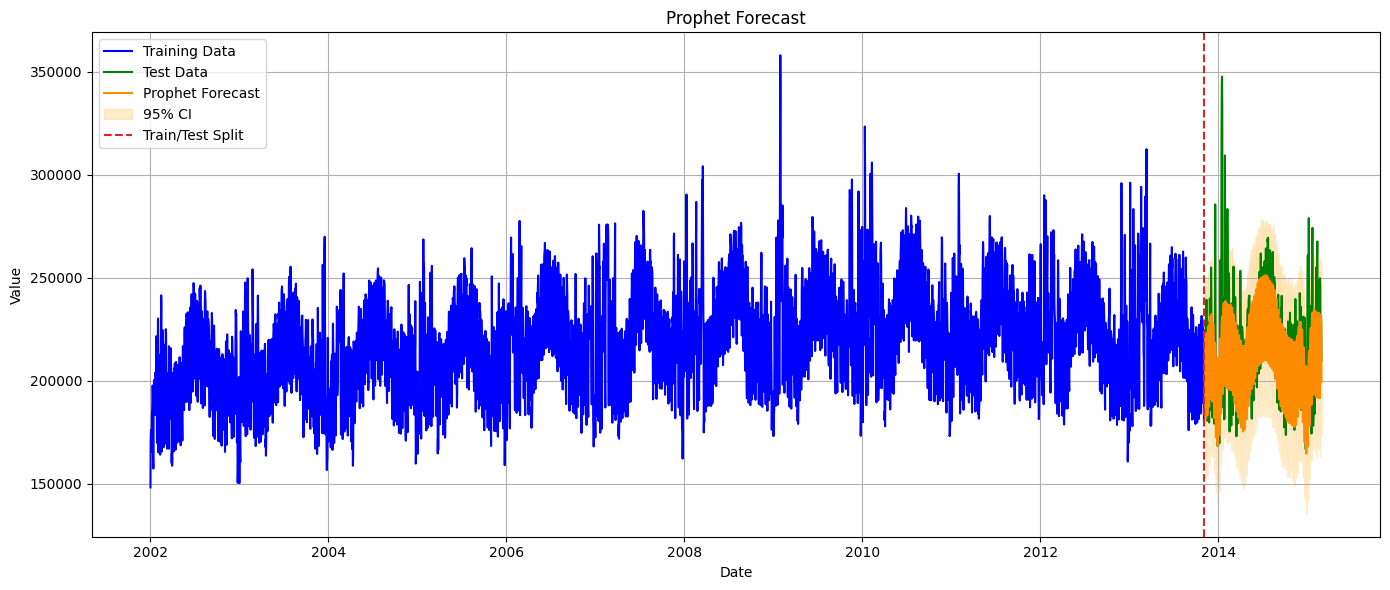

In [4]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1) 
yhat = prophet_forecast(train_df, test_df, show_plots=True)


18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:35 - cmdstanpy - INFO - Chain [1] done processing


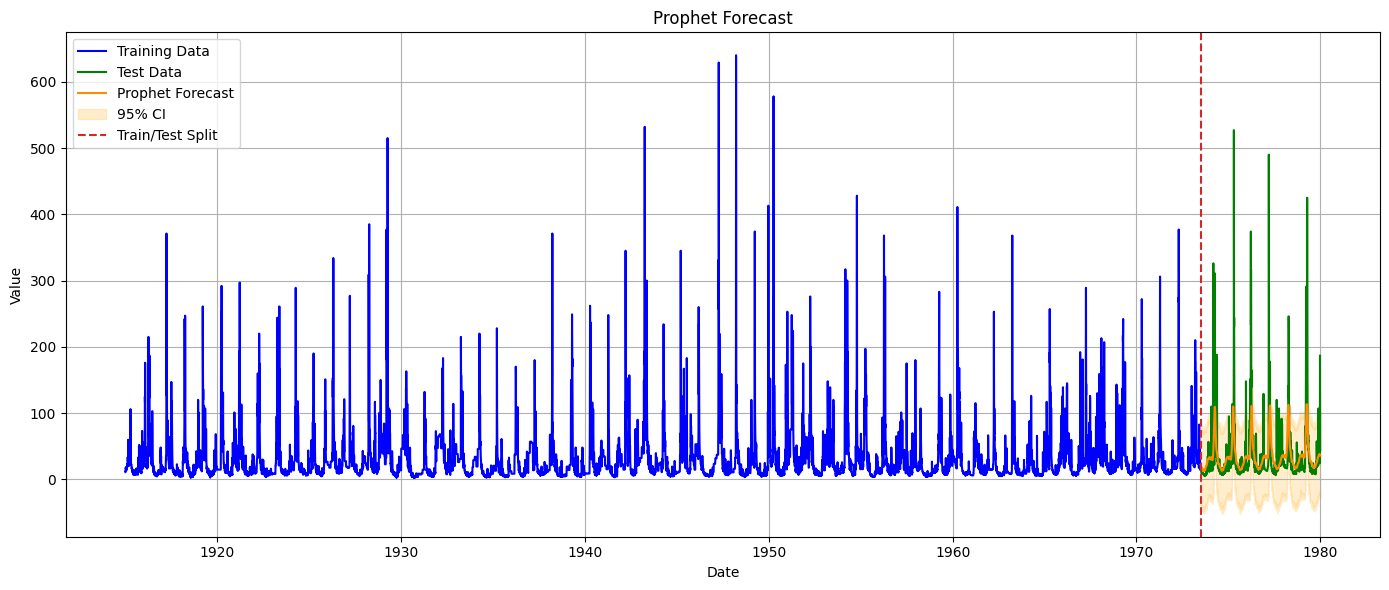

In [11]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
yhat = prophet_forecast(train_df, test_df, show_plots=True)

18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing


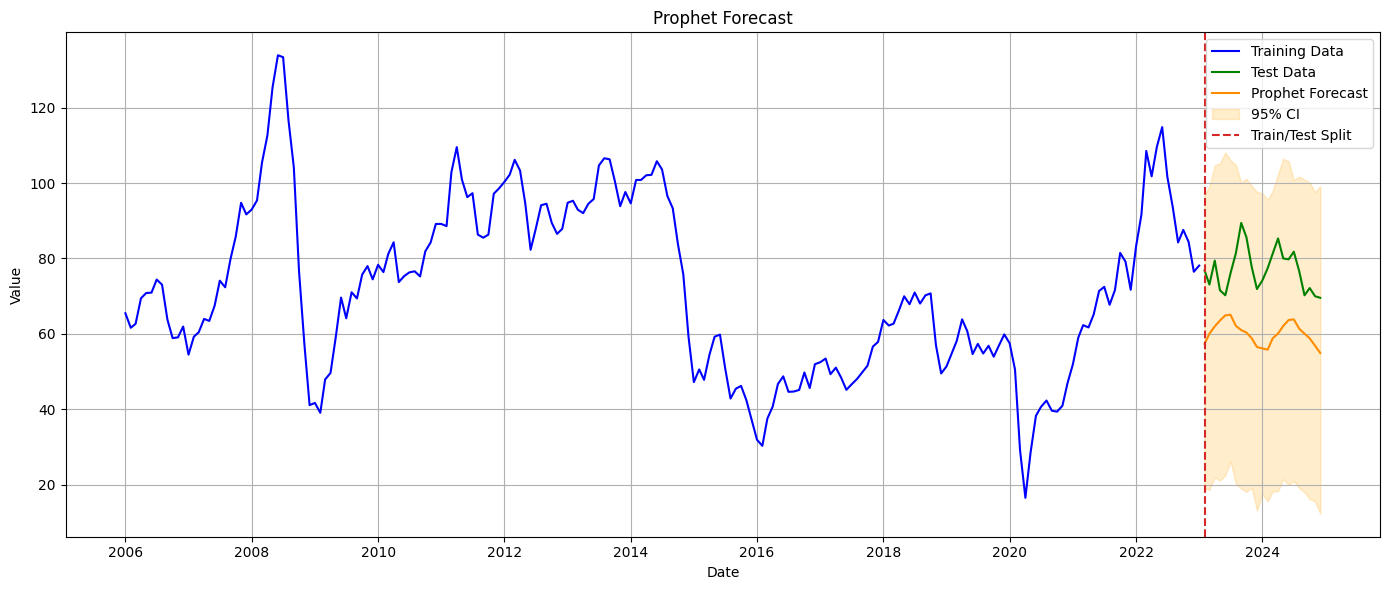

In [6]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
yhat = prophet_forecast(train_df, test_df, show_plots=True)
# yhat is a numpy array of predictions for the test set


18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing


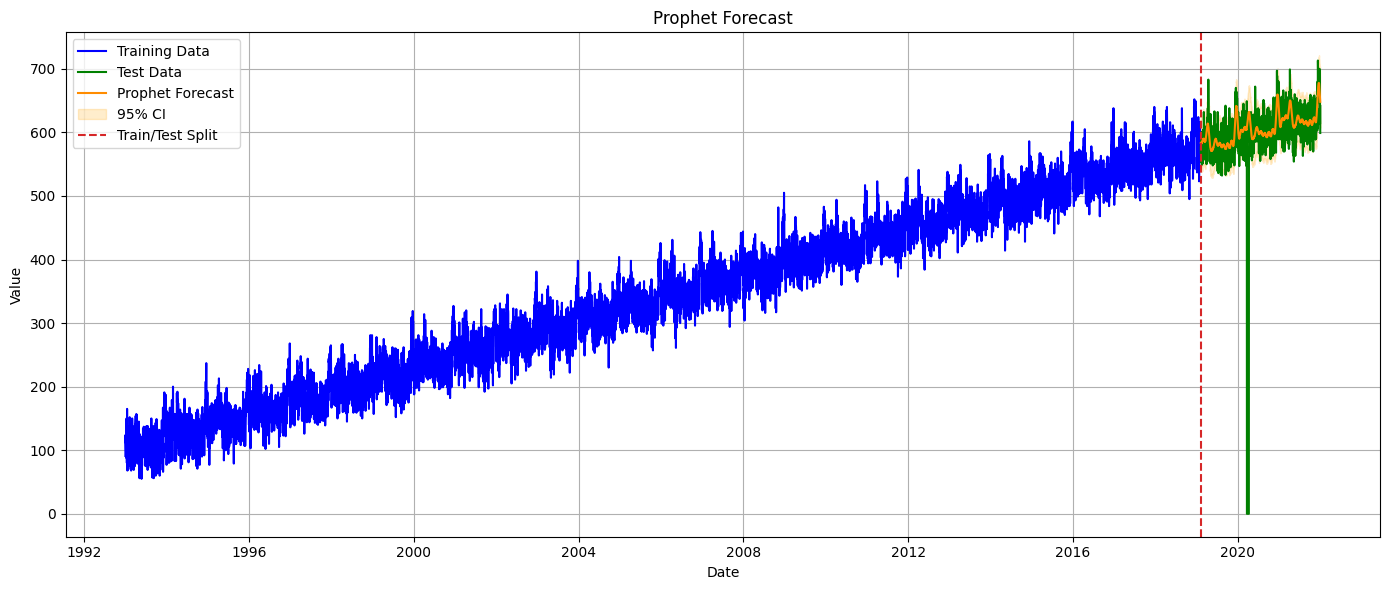

In [9]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
yhat = prophet_forecast(train_df, test_df, show_plots=True)


18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing


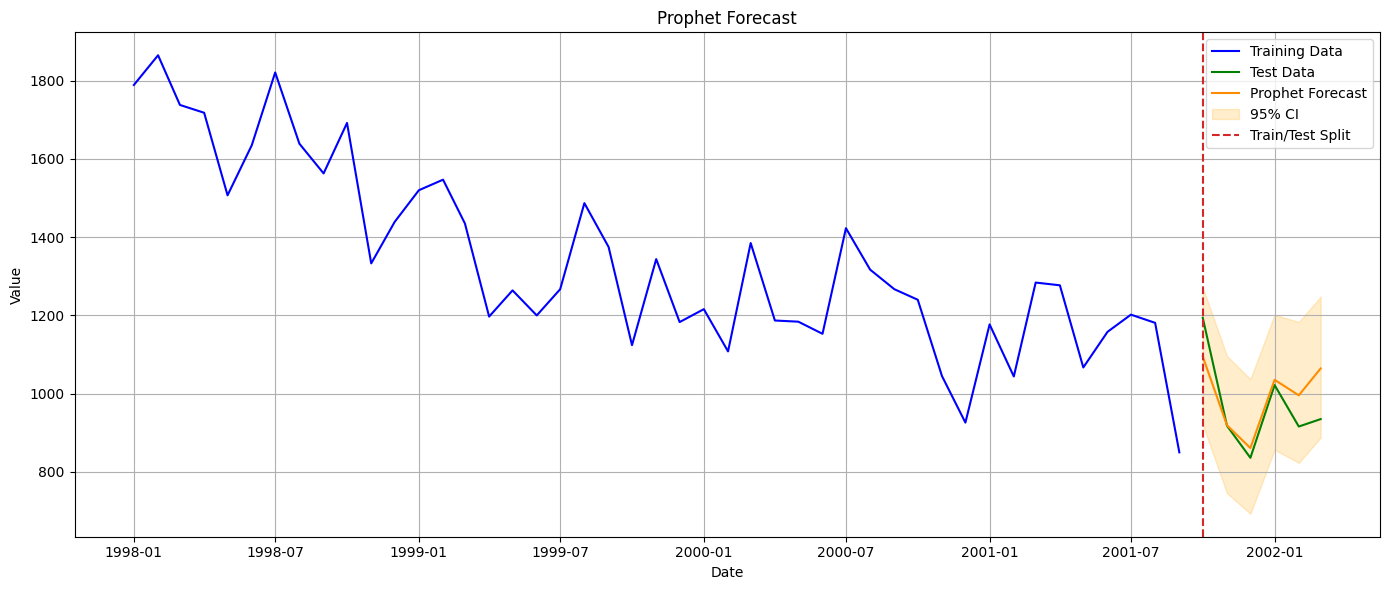

In [10]:
train_df, test_df = split_train_test(car_parts_df, test_size=0.1)
yhat = prophet_forecast(train_df, test_df, show_plots=True)


- Cross Validation

18:06:41 - cmdstanpy - INFO - Chain [1] start processing


Auto-inferred method name: 'prophet_forecast'


18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
18:06:44 - cmdstanpy - INFO - Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing


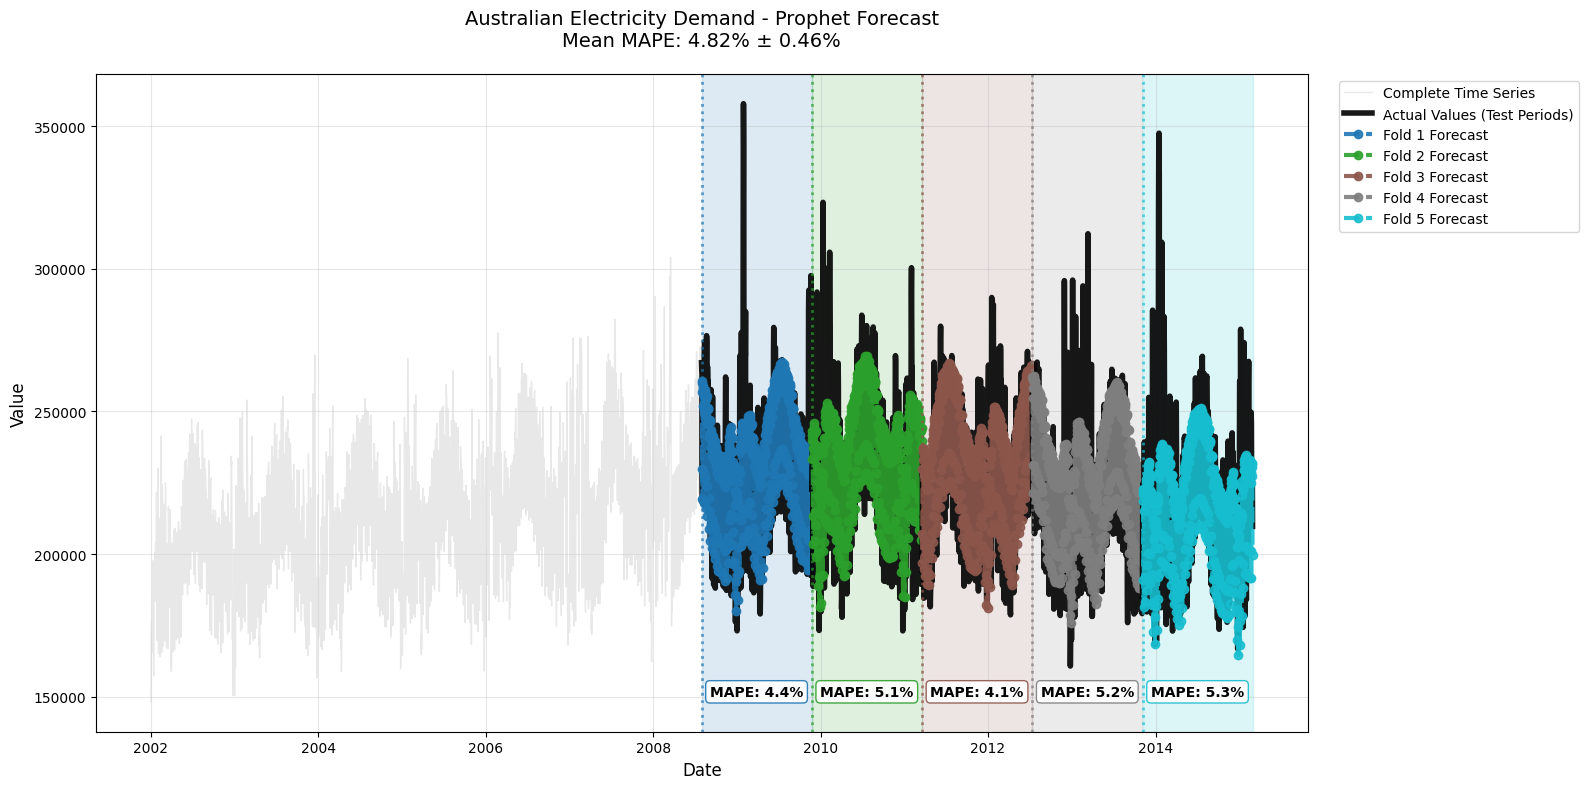


Results saved to cv_results.json under method 'prophet_forecast' for dataset 'australian_electricity_demand'
Auto-inferred method name: 'prophet_forecast'


18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:11 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing


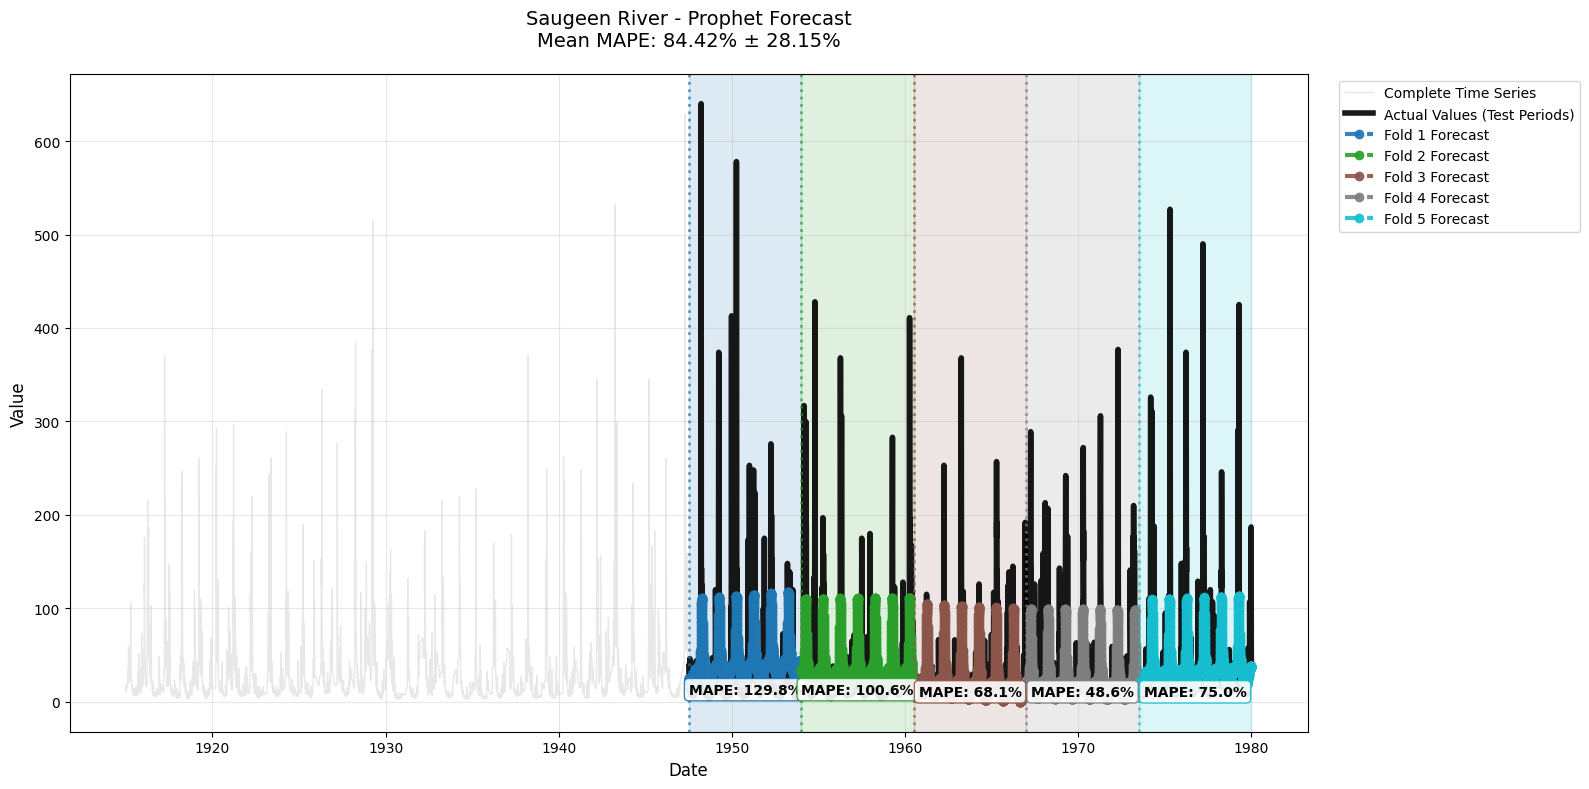

18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing



Results saved to cv_results.json under method 'prophet_forecast' for dataset 'saugeen_river'
Auto-inferred method name: 'prophet_forecast'


18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing


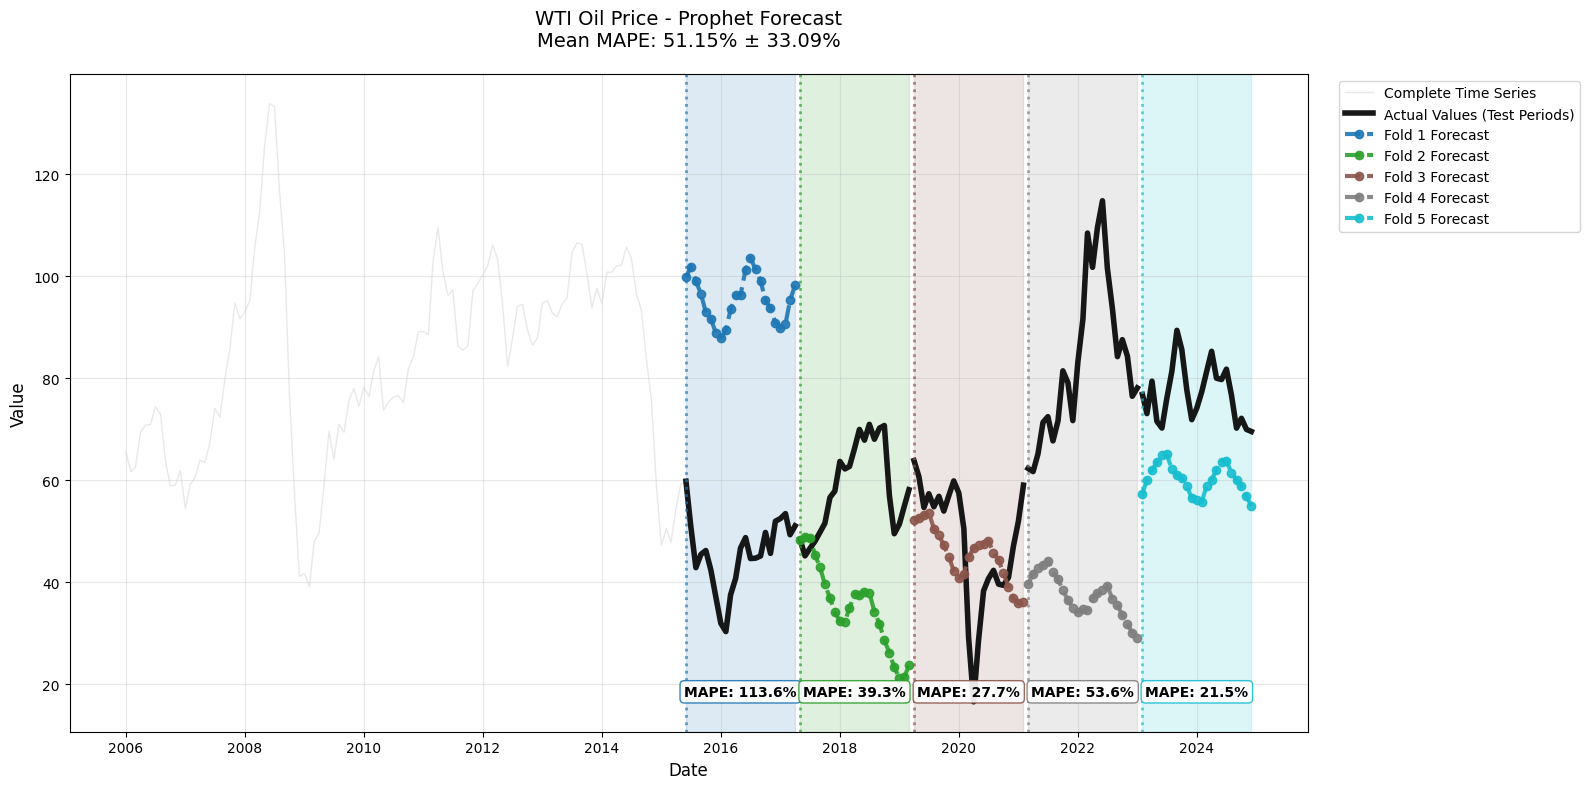


Results saved to cv_results.json under method 'prophet_forecast' for dataset 'wti_oil'
Auto-inferred method name: 'prophet_forecast'


18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:41 - cmdstanpy - INFO - Chain [1] done processing
18:07:43 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing


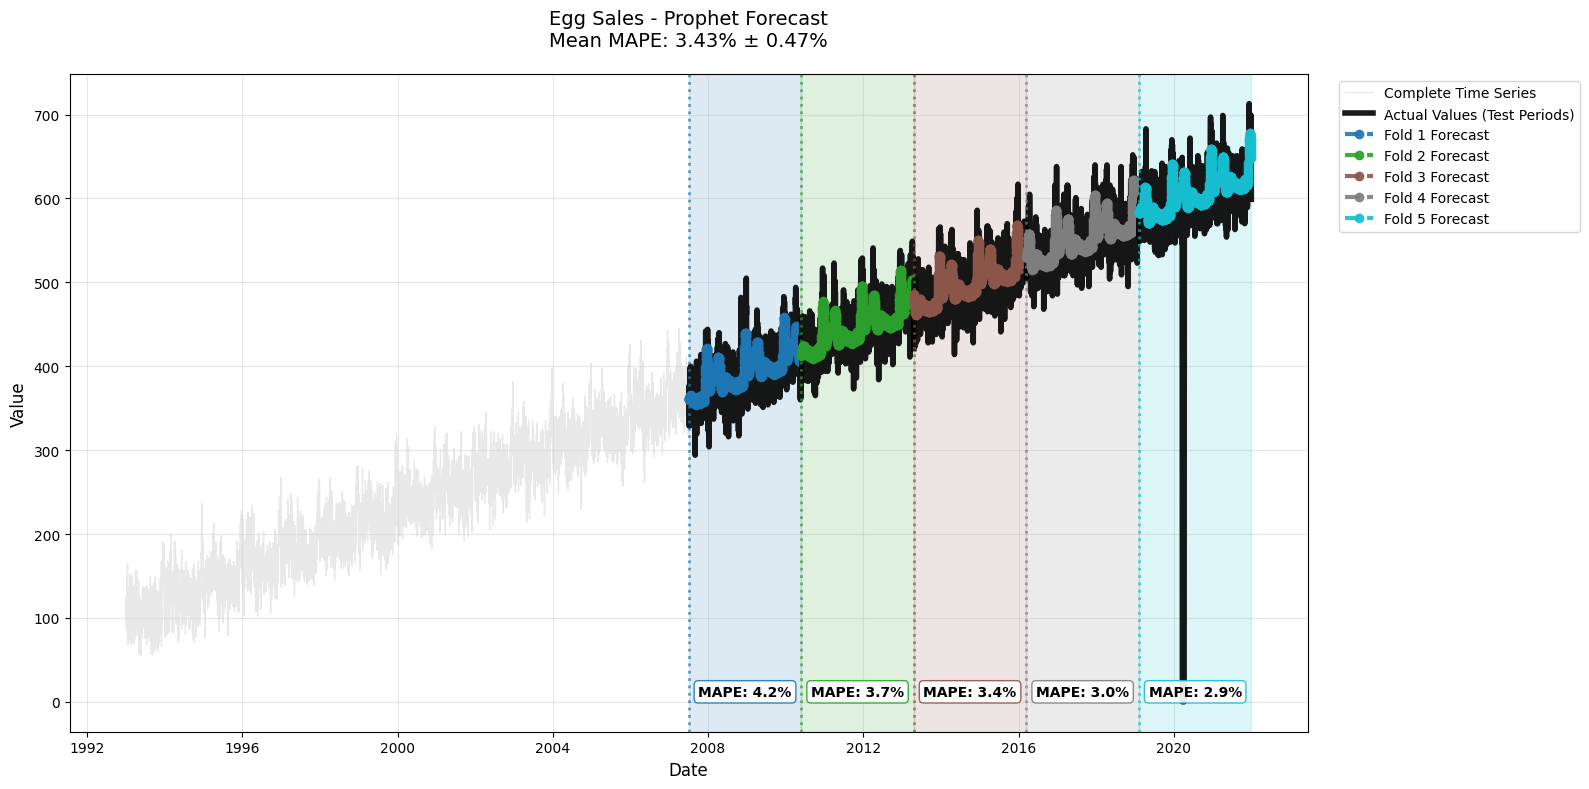

18:07:51 - cmdstanpy - INFO - Chain [1] start processing



Results saved to cv_results.json under method 'prophet_forecast' for dataset 'egg_sales'
Auto-inferred method name: 'prophet_forecast'


18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:52 - cmdstanpy - INFO - Chain [1] done processing
18:07:52 - cmdstanpy - INFO - Chain [1] start processing
18:07:52 - cmdstanpy - INFO - Chain [1] done processing


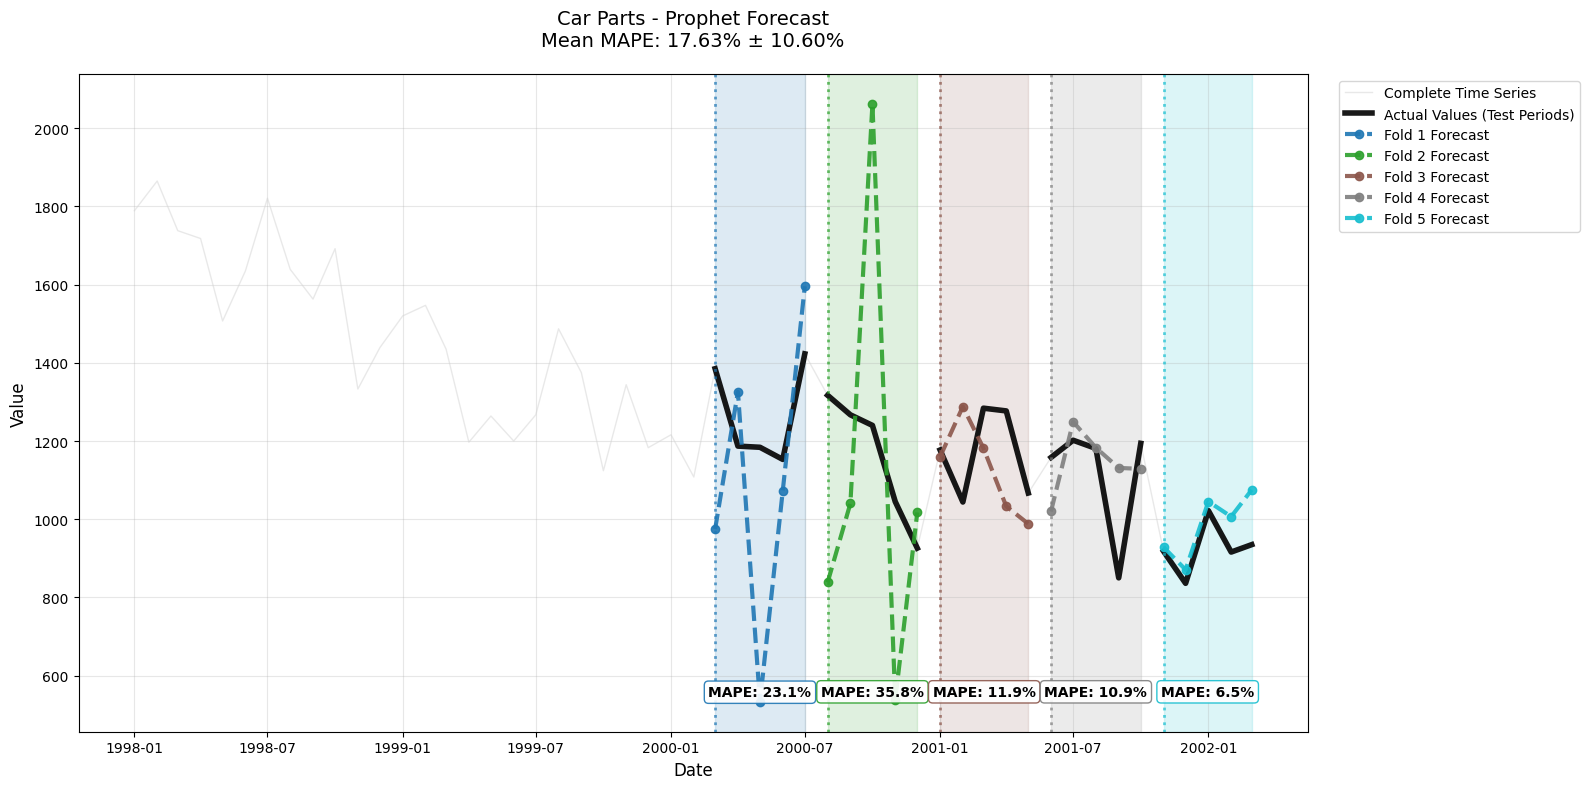


Results saved to cv_results.json under method 'prophet_forecast' for dataset 'car_parts'


In [12]:
# cv stands for cross validation in basic_functions.ipynb
plot_comprehensive_cv_results(australian_electricity_demand_df, prophet_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - Prophet Forecast")

plot_comprehensive_cv_results(saugeen_river_df, prophet_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - Prophet Forecast")

plot_comprehensive_cv_results(wti_oil_df, prophet_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - Prophet Forecast")

plot_comprehensive_cv_results(egg_sales_df, prophet_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - Prophet Forecast")

plot_comprehensive_cv_results(car_parts_df, prophet_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - Prophet Forecast")


----------------------------------------------------------------------------------------------------------------------------------------------------